# New York City Airbnb
Dataset source - [kaggle](kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

## Import modules

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler, 
                                   PolynomialFeatures)
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)
from sklearn.linear_model import (LassoCV,
                                  RidgeCV,
                                  ElasticNetCV)

## Read data

In [35]:
df = pd.read_csv('data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## EDA

In [36]:
to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
df.drop(to_drop, axis=1, inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [38]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Missing data
Посмотрим сколько данных отсутствует

In [39]:
df.isna().sum()/df.shape[0]

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

Пропуски в данных есть в столбце reviews_per_month, отсутствует 1/5 данных, убрать строки с пропусками не вариант.
Возможно эти данные отсутсвуют для записей с 0 number_of_reviews?

In [40]:
df[df.reviews_per_month.isna()].number_of_reviews.describe()

count    10052.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: number_of_reviews, dtype: float64

### Target distribution
Посмотрим распределение цены

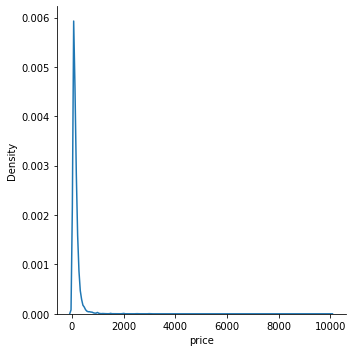

In [41]:
sns.displot(data=df, x='price', kind='kde')
plt.show()

99% цен ниже 800 долларов. Возможно стоит удалить выбросы?

In [42]:
np.quantile(df.price, 0.99)

799.0

Возможно целевую переменную стоит логарифмировать? 

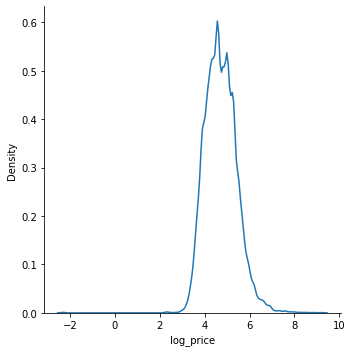

In [43]:
df['log_price'] = np.log(df.price.replace({0: 0.1}))
sns.displot(data=df, x='log_price', kind='kde')
plt.show()

In [44]:
df.room_type.value_counts(normalize=True)

Entire home/apt    0.519665
Private room       0.456611
Shared room        0.023724
Name: room_type, dtype: float64

In [45]:
df.neighbourhood_group.value_counts(normalize=True)

Manhattan        0.443011
Brooklyn         0.411167
Queens           0.115881
Bronx            0.022313
Staten Island    0.007629
Name: neighbourhood_group, dtype: float64

### Target distribution by other variables
Посмотрим на категориальные признаки и распределения цены между разными признаками.

In [46]:
cat_cols = ['room_type', 'neighbourhood_group', 'neighbourhood']
for col in cat_cols:
    cat_unique = df[col].unique()
    print(f'{col} ({len(cat_unique)})\n', df[col].unique())

room_type (3)
 ['Private room' 'Entire home/apt' 'Shared room']
neighbourhood_group (5)
 ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood (221)
 ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkin

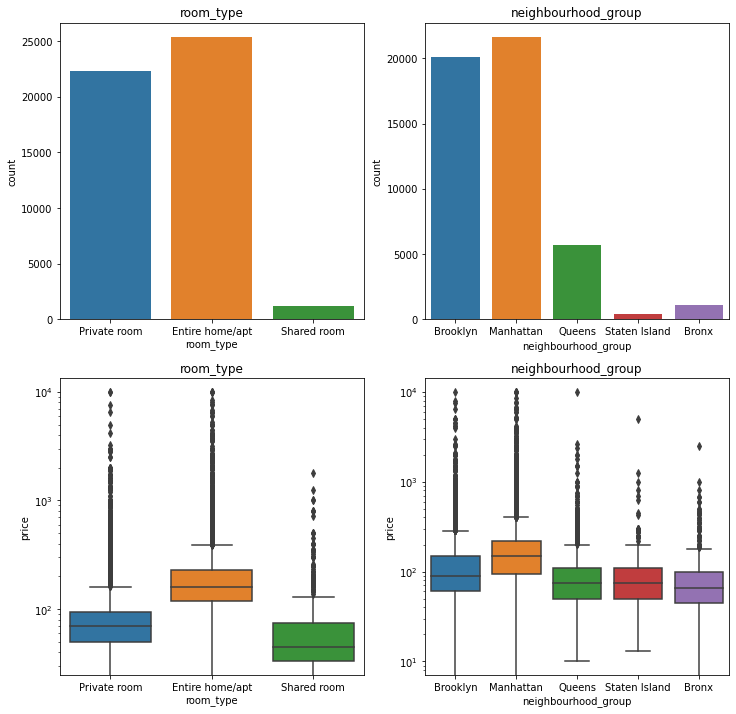

In [47]:
cats = ('room_type', 'neighbourhood_group')
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
for i, cat in enumerate(cats):
    # countplot
    ax[0,i].set_title(cat)
    sns.countplot(data=df, x=cat, ax=ax[0,i])
    # boxplot
    ax[1,i].set_title(cat)
    sns.boxplot(data=df, x=cat, y='price', ax=ax[1,i])
    ax[1,i].set_yscale('log')
plt.show()

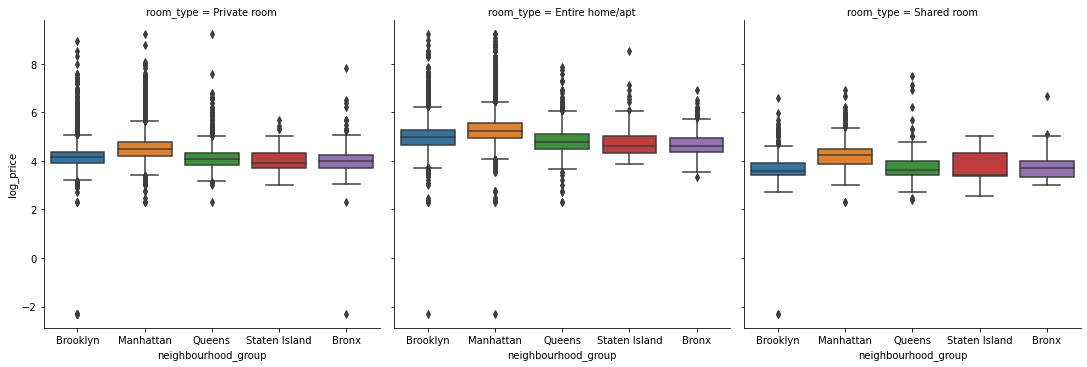

In [48]:
sns.catplot(kind='box', data=df, x='neighbourhood_group', y='log_price', col='room_type')
plt.show()

### Scatter plots

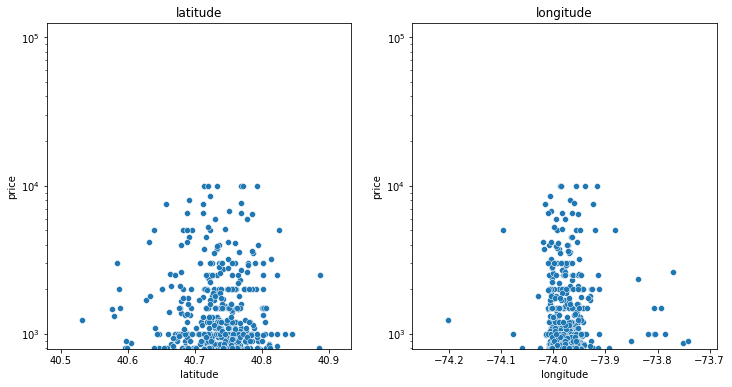

In [49]:
cols = ('latitude', 'longitude')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 6)
for i, col in enumerate(cols):
    ax[i].set_title(col)
    sns.scatterplot(data=df, x=col, y='price', ax=ax[i])
    ax[i].set_yscale('log')
plt.show()

Может быть расстояние до самого дорогого района (Манхеттена) будет лучше для предсказания цены?

In [50]:
mh_coord = np.array([40.7831, -73.9712])
df['dist_to_mh'] = np.sqrt((df.latitude-mh_coord[0])**2 + (df.longitude-mh_coord[1])**2)

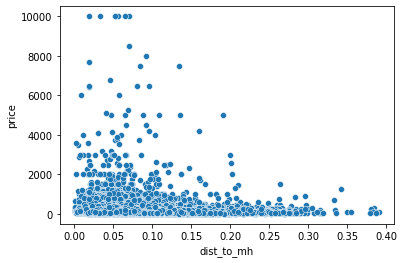

In [51]:
sns.scatterplot(data=df, x='dist_to_mh', y='price')
plt.show()

In [52]:
df.columns.tolist()

['neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'log_price',
 'dist_to_mh']

In [53]:
col_order = ['price',
             'log_price',
             'room_type',
             'latitude',
             'longitude',
             'dist_to_mh',
             'neighbourhood_group',
             'neighbourhood',             
             'minimum_nights',
             'number_of_reviews',
             'reviews_per_month', 
             'calculated_host_listings_count',
             'availability_365']
df = df[col_order]

### Correlation

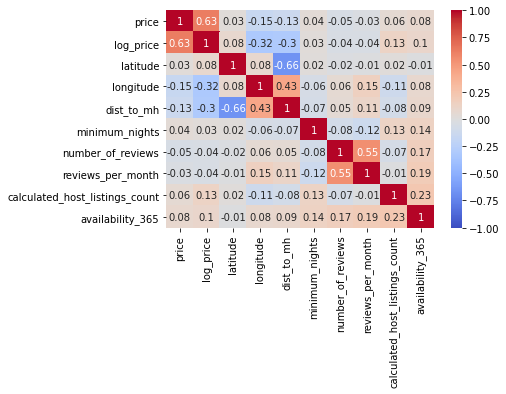

In [54]:
cor_tab = df.corr().apply(np.round, decimals=2)
# Palette
pal = sns.color_palette("coolwarm", 10000)
sns.heatmap(data=cor_tab, annot=True, cmap=pal, vmin=-1, center=0, vmax=1)
plt.show()

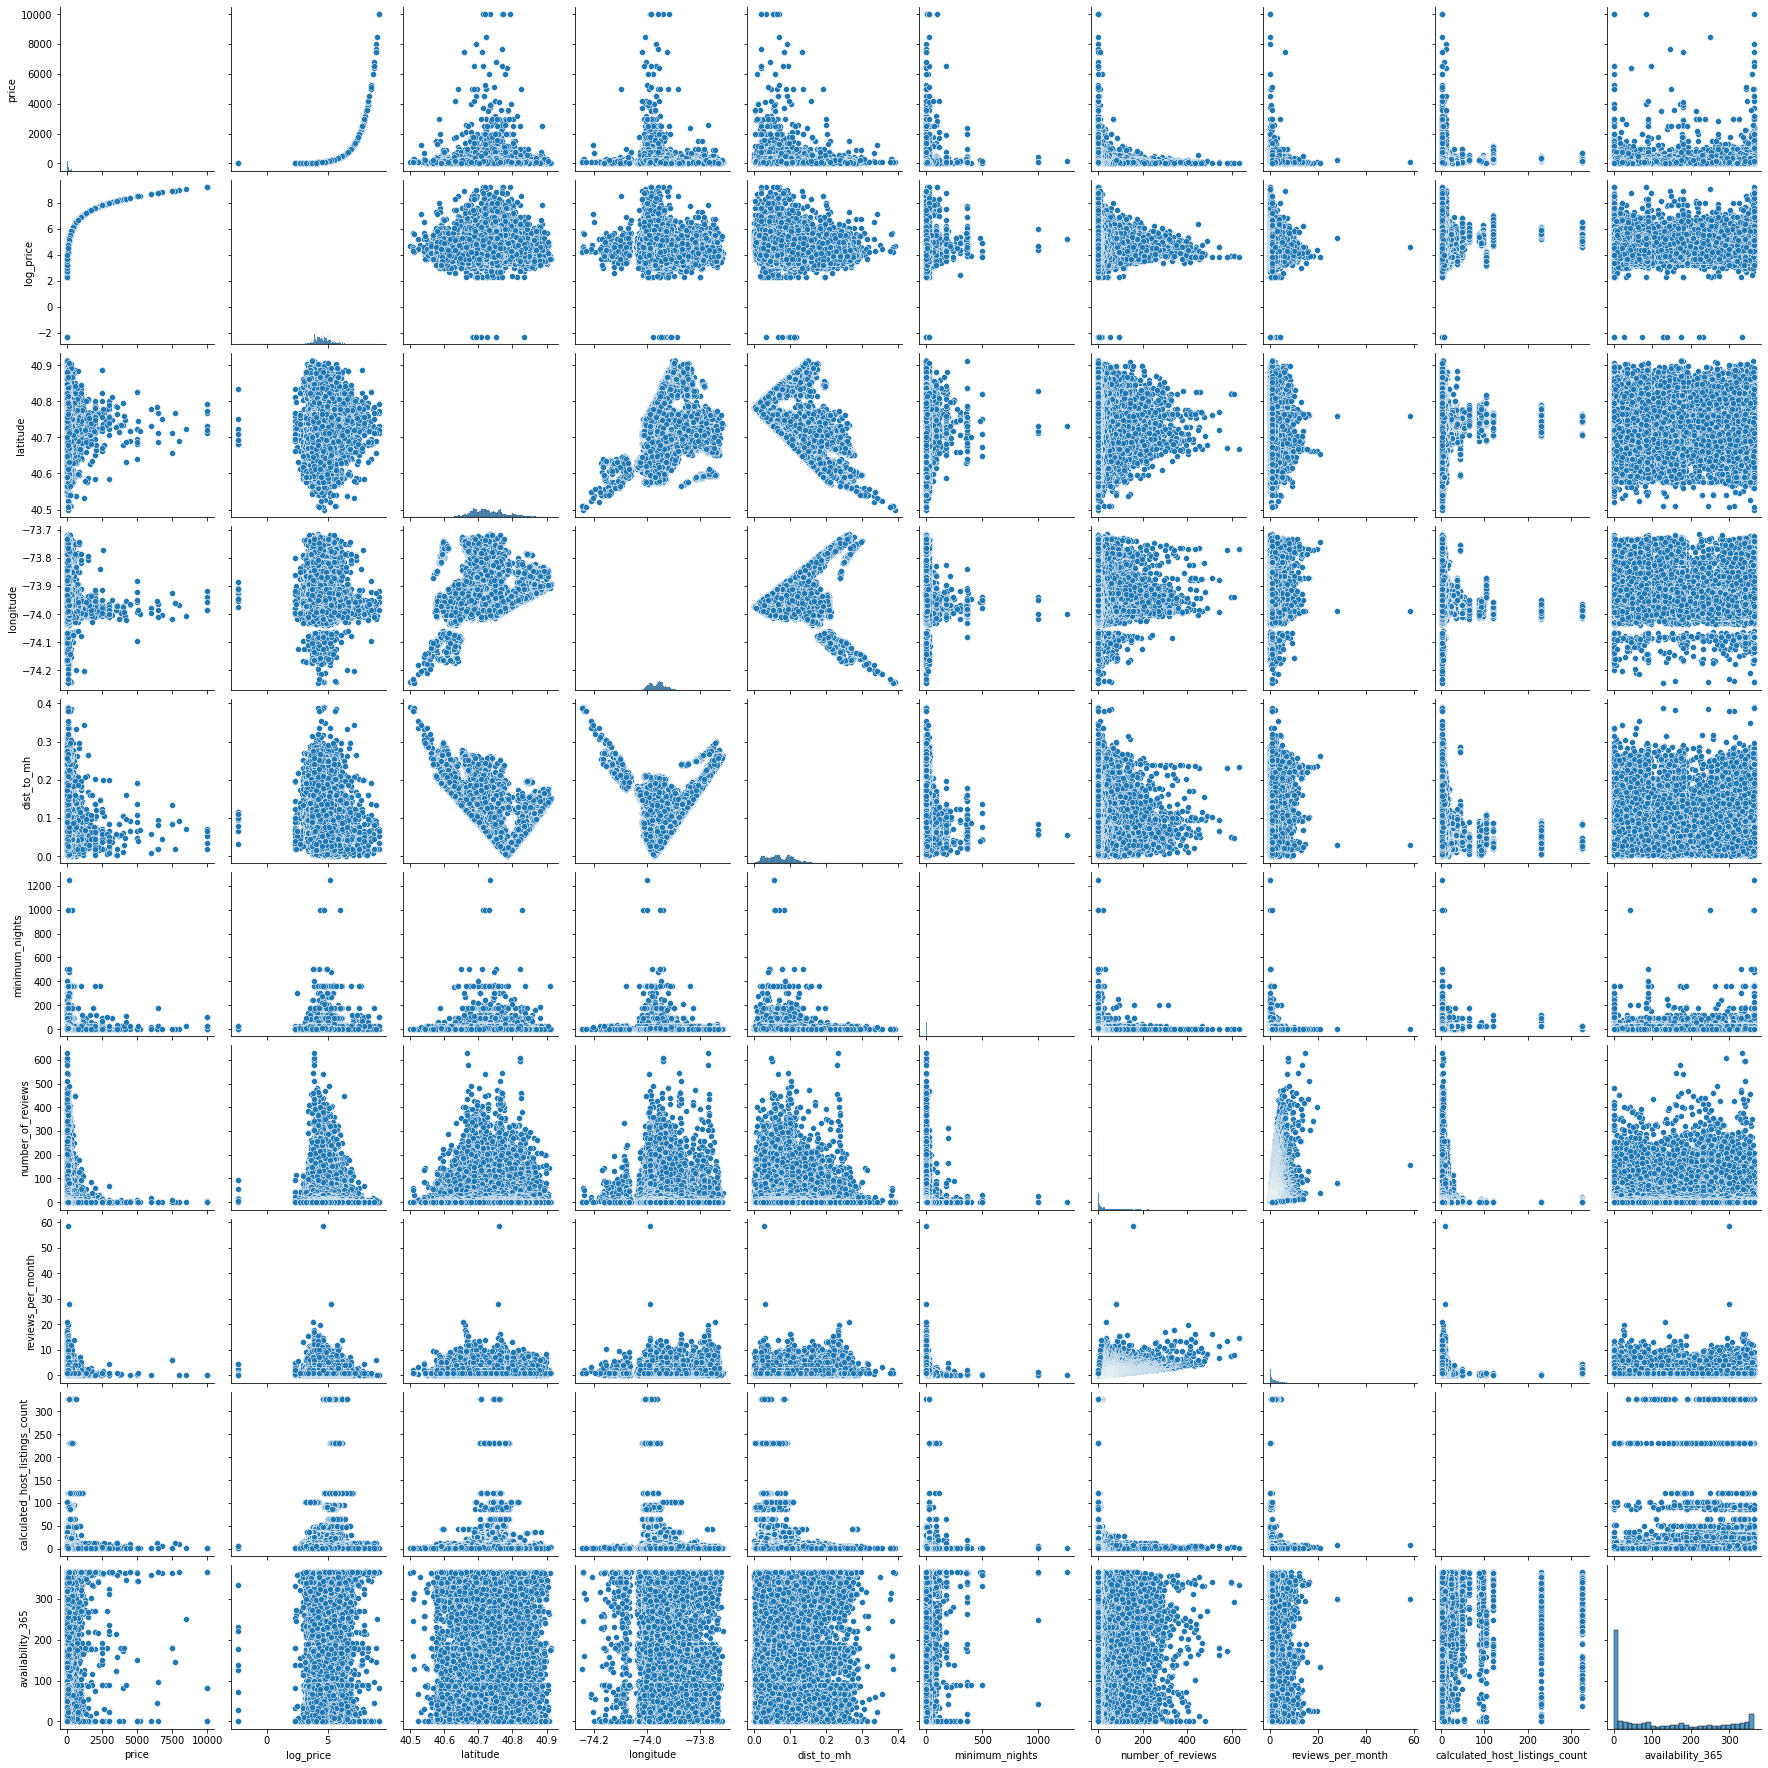

In [55]:
sns.pairplot(df)
plt.show()

## Pre-processing
### Missing data
Мы ранее выяснили, что данные reviews_per_month отсутствуют для записей с 0 number_of_reviews. Заменим отсутсвующие данные на специальное значение -1

In [56]:
df.reviews_per_month.fillna(-1, inplace=True)
df.reviews_per_month.isna().sum()

0

### Categorical variables
- neighbourhood_group - dummy
- neighbourhood - dummy
- room_type - ordinal

In [62]:
pr_df = df.copy(deep=True)
# neighbourhood_group, neighbourhood
pr_df = pd.get_dummies(pr_df, columns=['neighbourhood_group', 'neighbourhood'])
#pr_df.columns.tolist()

# room_type
rt_ord = {'Shared room': 1, 
          'Private room': 2, 
          'Entire home/apt': 3}
pr_df['room_type'] = pr_df.room_type.map(rt_ord)
pr_df.head()

,price,log_price,room_type,latitude,longitude,dist_to_mh,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
0,149,5.003946,2,40.64749,-73.97237,0.135615,1,9,0.21,6,...,0,0,0,0,0,0,0,0,0,0
1,225,5.416100,3,40.75362,-73.98377,0.032048,1,45,0.38,2,...,0,0,0,0,0,0,0,0,0,0
2,150,5.010635,2,40.80902,-73.94190,0.039120,3,0,-1.00,1,...,0,0,0,0,0,0,0,0,0,0
3,89,4.488636,3,40.68514,-73.95976,0.098626,1,270,4.64,1,...,0,0,0,0,0,0,0,0,0,0
4,80,4.382027,3,40.79851,-73.94399,0.031271,10,9,0.10,1,...,0,0,0,0,0,0,0,0,0,0


### Outliers
99% данных целевой переменной попадают в интервал между 0 и 800. Мы можем позволить себе дропнуть 1% выбросов

In [63]:
print(np.quantile(pr_df.price, 0.99))
pr_df = pr_df[pr_df.price <= 800]

799.0


### Feature engineering
Scaling:
1. Normalization (MinMaxScaler)
2. Standardization (StandardScaler)
3. Robust to outliers (RobustScaler)

Target variable:
1. Raw
2. Log

Features:
1. All
2. w/o neighbourhood
3. w/o longitude and latitude
4. w/o distance to Manhattan

Additional:
1. PolynomialFeatures чтобы поймать нелинейный зависимости

In [59]:
# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(pr_df.drop(['price', 'log_price'], axis=1), 
                                                    test_size=0.3, 
                                                    random_state=77)


## Modeling